In [42]:
from matplotlib import pyplot as plt
from statsmodels.graphics.gofplots import qqplot
import numpy as np
import pandas as pd
import os
import math
import scipy.stats as stats
import copy
import functools
import statistics

%matplotlib inline

In [2]:
from trackml.dataset import load_event
hits_list = [load_event('data/train_100_events/event00000' + str(i))[0] for i in range (1000,1100)]
hits = pd.concat(hits_list, axis = 0)
cells_list = [load_event('data/train_100_events/event00000' + str(i))[1] for i in range (1000,1100)]
cells = pd.concat(cells_list, axis = 0)
particles_list = [load_event('data/train_100_events/event00000' + str(i))[2] for i in range (1000,1100)]
particles = pd.concat(particles_list, axis = 0)
truth_list = [load_event('data/train_100_events/event00000' + str(i))[3] for i in range (1000,1100)]
truth = pd.concat(truth_list, axis = 0)

In [58]:
def expected_freq_computation_continuous(cdf,partition_separators,n):
    expected_freq = []
    for i in range(0,len(partition_separators) + 1):
        if i == 0:
            sep_1 = partition_separators[i]
            expected_freq.append(cdf(sep_1)*n)
        elif i == len(partition_separators):
            sep_2 = partition_separators[i-1]
            expected_freq.append((1-cdf(sep_2))*n)
        else:
            sep_1 = partition_separators[i]
            sep_2 = partition_separators[i-1]
            expected_freq.append((cdf(sep_1) - cdf(sep_2))*n)
    return expected_freq

def merge_partition(i_lower, ps, c):
    counts = copy.deepcopy(c)
    partition_separators = copy.deepcopy(ps)
    i = i_lower
    counts[i+1] = counts[i] + counts[i+1]
    del counts[i]
    del partition_separators[i]
    return (partition_separators, counts)

In [3]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1
1,2,-55.336102,0.635342,-1502.5,7,2,1
2,3,-83.830498,-1.143010,-1502.5,7,2,1
3,4,-96.109100,-8.241030,-1502.5,7,2,1
4,5,-62.673599,-9.371200,-1502.5,7,2,1


In [4]:
cells.head()

,hit_id,ch0,ch1,value
0,1,209,617,0.013832
1,1,210,617,0.079887
2,1,209,618,0.211723
3,2,68,446,0.334087
4,3,58,954,0.034005


In [5]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824902,1,3


In [6]:
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


In [7]:
particles.size

9712314

(array([2.33126e+05, 5.10850e+04, 8.50300e+04, 8.16000e+04, 2.26186e+05,
        3.45775e+05, 5.08740e+04, 5.39800e+03, 6.50000e+01, 7.00000e+00]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

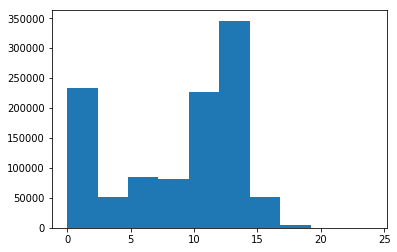

In [8]:
plt.hist(particles.nhits)

In [9]:
pos_part = particles[particles.q == 1]
neg_part = particles[particles.q == -1]

(array([1.45133e+05, 3.07830e+04, 3.35920e+04, 6.09430e+04, 1.11618e+05,
        1.41537e+05, 6.95210e+04, 3.09100e+03, 2.10000e+02, 1.30000e+01]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

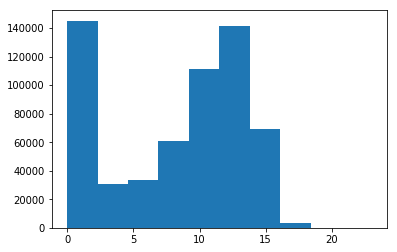

In [10]:
plt.hist(pos_part.nhits)

(array([8.79930e+04, 2.03020e+04, 3.41450e+04, 3.79500e+04, 1.14568e+05,
        1.63092e+05, 2.24990e+04, 2.13500e+03, 1.90000e+01, 2.00000e+00]),
 array([ 0. ,  2.4,  4.8,  7.2,  9.6, 12. , 14.4, 16.8, 19.2, 21.6, 24. ]),
 <a list of 10 Patch objects>)

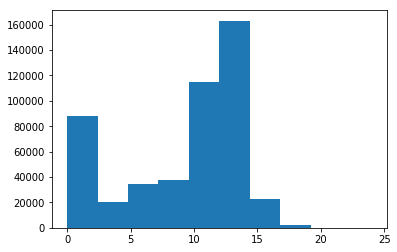

In [11]:
plt.hist(neg_part.nhits)

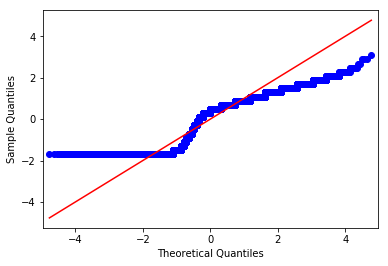

In [12]:
fig = qqplot(particles.nhits, fit = True, line='s')


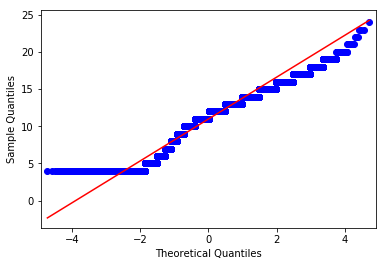

In [13]:
trunc_nhits = particles[particles.nhits >3].nhits
fig = qqplot(trunc_nhits, line='s')

### Analysis

Wtf is going with the LHS of the QQ plot?

(array([5.43260e+04, 5.71710e+04, 8.16000e+04, 2.26186e+05, 2.70160e+05,
        1.12117e+05, 1.86080e+04, 1.16200e+03, 6.50000e+01, 7.00000e+00]),
 array([ 4.,  6.,  8., 10., 12., 14., 16., 18., 20., 22., 24.]),
 <a list of 10 Patch objects>)

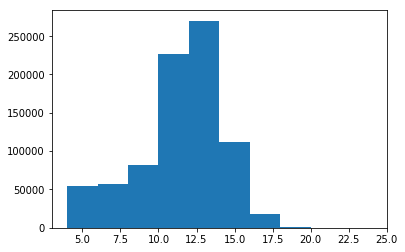

In [14]:
plt.hist(trunc_nhits)


# Adding Noise Because Discrete Data Looks Weird

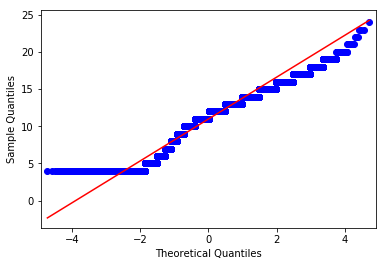

In [15]:
s = 0.0001
eps = np.random.normal(0,s, trunc_nhits.shape)
trunc_nhits_random = trunc_nhits + eps

fig = qqplot(trunc_nhits_random, line='s')

# Analysis

By adding noise, we see that normality is restored, so we can trust that QQ-plot is working

# Straight Shot Paths Through Analyzing Truth

# Is total hits in an event normally distributed?

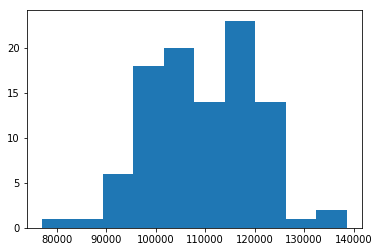

In [65]:
hits_per_event = [hits.shape[0] for hits in hits_list]
hpe_counts, hpe_partition, _ = plt.hist(hits_per_event)
hpe_counts = list(hpe_counts)
hpe_partition = list(hpe_partition)


## Chi-Square Test

In [66]:

hpe_counts.insert(0,0)
hpe_counts.append(0)
hpe_partition, hpe_counts = merge_partition(0,hpe_partition,hpe_counts)                                           
hpe_partition, hpe_counts = merge_partition(0,hpe_partition,hpe_counts)
hpe_partition, hpe_counts = merge_partition(0,hpe_partition,hpe_counts)
hpe_partition, hpe_counts = merge_partition(len(hpe_partition)-1, hpe_partition, hpe_counts)
hpe_partition, hpe_counts = merge_partition(len(hpe_partition)-1, hpe_partition, hpe_counts)
hpe_partition, hpe_counts = merge_partition(len(hpe_partition)-1, hpe_partition, hpe_counts)

partial_norm_cdf = functools.partial(stats.norm.cdf, loc = statistics.mean(hits_per_event), scale = statistics.stdev(hits_per_event))
expected_counts = expected_freq_computation_continuous(partial_norm_cdf,hpe_partition,sum(hpe_counts))
stats.chisquare(hpe_counts,expected_counts, 2)

Power_divergenceResult(statistic=6.369156618725524, pvalue=0.09496795668496887)

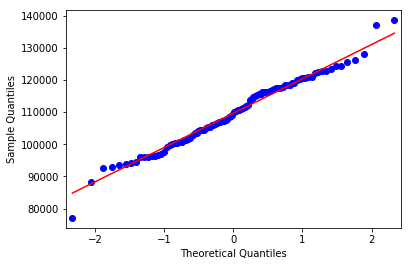

In [17]:
fig = qqplot(np.array(hits_per_event), line='s')

## Conclusion

The total number of hist per event is normally distributed.
QQ-plot shows this and we also fail to reject the null hypothesis in the chi-square test

# "Most Normal" Chopping Off From Bimodal

(array([7.3463e+04, 1.6164e+04, 1.7465e+04, 3.4523e+04, 7.1492e+04,
        8.4818e+04, 3.9726e+04, 1.6020e+03, 8.2000e+01, 5.0000e+00]),
 array([ 0. ,  2.3,  4.6,  6.9,  9.2, 11.5, 13.8, 16.1, 18.4, 20.7, 23. ]),
 <a list of 10 Patch objects>)

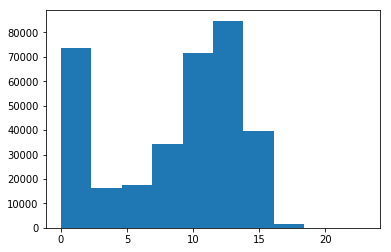

In [18]:
first_30_events_particles = pd.concat(particles_list[0:30], axis = 0) # for training
part_nhits_30 = first_30_events_particles.nhits
plt.hist(part_nhits_30)

NormaltestResult(statistic=4745.853121845855, pvalue=0.0)


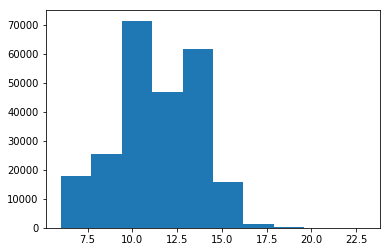

In [19]:
#for i in range (min(part_nhits_30)-1,max(part_nhits_30)):

trunc_i = first_30_events_particles[first_30_events_particles.nhits > 5].nhits.tolist()
plt.hist(trunc_i)
if(len(trunc_i) > 11):
    print(stats.normaltest(trunc_i))
    

## Analysis

Garbage, P-values were all small! Couldn't extract normality even in training!

# Is The Proportion of Ch0 and Ch1 the same?

(array([18562012., 19040633., 15674076.,  3077028.,  2516233.,   457809.,
          352345.,   284716.,   139973.,    54384.]),
 array([   0. ,  119.9,  239.8,  359.7,  479.6,  599.5,  719.4,  839.3,
         959.2, 1079.1, 1199. ]),
 <a list of 10 Patch objects>)

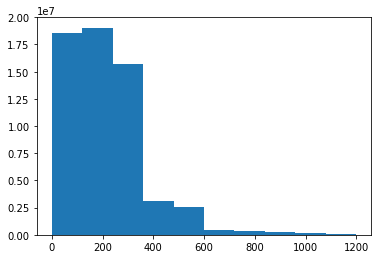

In [20]:
plt.hist(cells.ch0)

(array([22945002.,  4360020.,  4290337.,  4265624.,  4203794.,  4138767.,
         4084391.,  4040315.,  3970327.,  3860632.]),
 array([   0. ,  127.9,  255.8,  383.7,  511.6,  639.5,  767.4,  895.3,
        1023.2, 1151.1, 1279. ]),
 <a list of 10 Patch objects>)

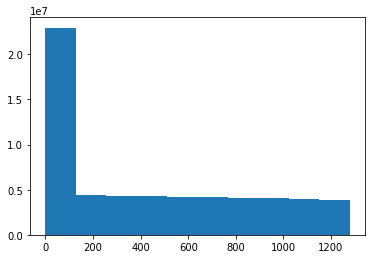

In [21]:
plt.hist(cells.ch1)

## Analysis

Seems a little complicated ... idea: each 'cell' might have a different range for ch0 and ch1 so we need to deal with that. Idea, we need to get cells which have a small range and a high number of hits in order to determine whether there is a normal distribution or not. 

Problem: "Depending on the detector type only one of the channel identifiers is valid, e.g. for the strip detectors, and the value might have different resolution." Also, the geometry file does not seem to indicate what the range of ch0 and ch1 for each detector is.

# Is the proportion of particles never detected constant across each collision?

Hypothesis: the proportion should be normal with a 'small' variance

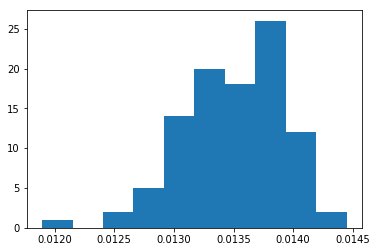

In [76]:
p_list = []
for i in range(0, len(hits_list)):
    no_hits_count = 0
    for j in range(0,particles_list[i].shape[0]):
        if particles_list[i]['nhits'][j] == 0:
            no_hits_count += 1
    p_list.append(float(no_hits_count)/float(hits_list[i].shape[0]))
hpe_counts, hpe_partition, _ = plt.hist(p_list)
hpe_counts = list(hpe_counts)
hpe_partition = list(hpe_partition)

## Chi-Square Test

In [77]:

hpe_counts.insert(0,0)
hpe_counts.append(0)
hpe_partition, hpe_counts = merge_partition(0,hpe_partition,hpe_counts)                                           
hpe_partition, hpe_counts = merge_partition(0,hpe_partition,hpe_counts)
hpe_partition, hpe_counts = merge_partition(0,hpe_partition,hpe_counts)
hpe_partition, hpe_counts = merge_partition(0,hpe_partition,hpe_counts)
hpe_partition, hpe_counts = merge_partition(len(hpe_partition)-1, hpe_partition, hpe_counts)
hpe_partition, hpe_counts = merge_partition(len(hpe_partition)-1, hpe_partition, hpe_counts)
partial_norm_cdf = functools.partial(stats.norm.cdf, loc = statistics.mean(p_list), scale = statistics.stdev(p_list))
expected_counts = expected_freq_computation_continuous(partial_norm_cdf,hpe_partition,sum(hpe_counts))
stats.chisquare(hpe_counts,expected_counts, 2)

Power_divergenceResult(statistic=4.823731732046528, pvalue=0.18516885041107395)

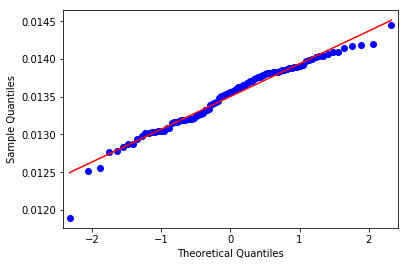

In [23]:
fig = qqplot(np.array(p_list), line='s')

## Analysis

QQ-plot and P-value both indicate normality

# A Meticulous Analysis of the Initial Angles of the Particles

In [86]:
thetas = []
phis = []
norms = []
for i in range(0,particles_list[0].shape[0]):
    x = particles_list[0]['px'][i]
    y = particles_list[0]['py'][i]
    z = particles_list[0]['pz'][i]
    norms.append(math.sqrt(x*x + y*y + z*z))
    thetas.append(math.atan2(y,x))
    phis.append(math.acos(z/norms[i]))
    

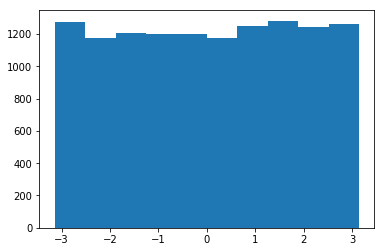

In [91]:
hpe_counts, hpe_partition, _ = plt.hist(thetas)
hpe_counts = list(hpe_counts)
hpe_partition = list(hpe_partition)

## $\theta$ Chi-Square Test for Uniformity

In [92]:
hpe_counts.insert(0,0)
hpe_counts.append(0)
a = min(thetas)
b = max(thetas)
hpe_partition, hpe_counts = merge_partition(0,hpe_partition,hpe_counts)
hpe_partition, hpe_counts = merge_partition(len(hpe_partition)-1, hpe_partition, hpe_counts)
partial_unif_cdf = functools.partial(stats.uniform.cdf, loc = a, scale = b-a)
expected_counts = expected_freq_computation_continuous(partial_unif_cdf,hpe_partition,sum(hpe_counts))
stats.chisquare(hpe_counts,expected_counts, 2)

Power_divergenceResult(statistic=12.173285492946379, pvalue=0.09500236619340857)

(array([2653.,  995.,  866.,  769.,  859.,  860.,  833.,  771., 1025.,
        2632.]),
 array([0.03662991, 0.34383297, 0.65103603, 0.95823909, 1.26544215,
        1.57264521, 1.87984827, 2.18705133, 2.49425439, 2.80145744,
        3.1086605 ]),
 <a list of 10 Patch objects>)

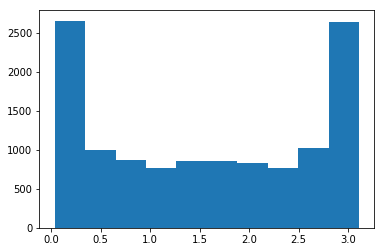

In [26]:
plt.hist(phis)

(array([1.2235e+04, 2.1000e+01, 5.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00735817e-01, 4.62667451e+01, 9.24327543e+01, 1.38598764e+02,
        1.84764773e+02, 2.30930782e+02, 2.77096791e+02, 3.23262801e+02,
        3.69428810e+02, 4.15594819e+02, 4.61760828e+02]),
 <a list of 10 Patch objects>)

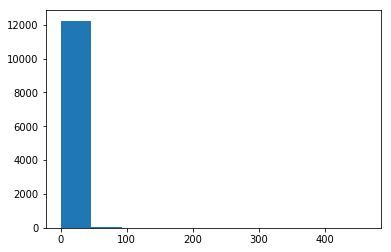

In [27]:
plt.hist(norms)

## Filtering out IQR

In [94]:
normsdf = pd.DataFrame(norms)
Q1 = normsdf[0].quantile(0.25)
Q3 = normsdf[0].quantile(0.75)
IQR = Q3 - Q1

normsdf_iqr = normsdf[(Q1 - 1.5*IQR <= normsdf[0]) & (normsdf[0] <= Q3 + 1.5*IQR)]

print(normsdf_iqr)


              0
0      0.385964
1      2.271788
2      1.124602
3      1.227834
5      3.983595
6      6.200329
7      0.546923
8      1.794422
9      0.248157
10     0.535478
11     5.378609
12     5.272305
13     5.818588
15     4.007491
16     6.984887
17     3.663112
18     2.267978
19     1.005222
20     4.643914
21     7.518519
22     1.622256
23     1.034061
24     2.306245
25     0.573479
26     0.333182
27     1.699170
28     5.451048
29     0.298398
30     0.731802
31     0.505140
...         ...
12233  0.840950
12234  2.851312
12235  0.858193
12236  1.211865
12237  0.388219
12238  0.806105
12239  0.262644
12240  0.133099
12241  0.134767
12242  0.438728
12243  0.606220
12244  1.303399
12245  1.305734
12246  0.138008
12247  0.492097
12248  0.223443
12249  0.284233
12250  0.251187
12251  0.202943
12252  0.446556
12253  1.079898
12254  0.186033
12255  0.785772
12256  1.002594
12257  1.042459
12258  0.185900
12259  0.300697
12260  1.347183
12261  0.431467
12262  0.192788

[10987 

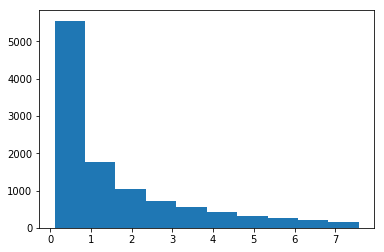

In [115]:
hpe_counts, hpe_partition, _ = plt.hist(normsdf_iqr[0])
hpe_counts = list(hpe_counts)
hpe_partition = list(hpe_partition)

In [116]:
hpe_counts.insert(0,0)
hpe_counts.append(0)
hpe_partition, hpe_counts = merge_partition(0,hpe_partition,hpe_counts)
hpe_partition, hpe_counts = merge_partition(len(hpe_partition)-1, hpe_partition, hpe_counts)
print(hpe_counts)
print(hpe_partition)
partial_unif_cdf = functools.partial(stats.expon.cdf, loc = 0, scale = statistics.mean(normsdf_iqr[0]))
expected_counts = expected_freq_computation_continuous(partial_unif_cdf,hpe_partition,sum(hpe_counts))
print(expected_counts)
stats.chisquare(hpe_counts,expected_counts, 2)

[5552.0, 1773.0, 1028.0, 709.0, 547.0, 420.0, 320.0, 271.0, 199.0, 168.0]
[0.8488899874155892, 1.5970441582471606, 2.345198329078732, 3.0933524999103037, 3.8415066707418752, 4.589660841573446, 5.337815012405017, 6.085969183236589, 6.8341233540681605]
[4552.557976583711, 2419.148837660243, 1509.6245809406678, 942.0529815703527, 587.8705416498982, 366.84961514973526, 228.92564025713082, 142.8567636516299, 89.14709116067226, 147.96597137595933]


Power_divergenceResult(statistic=903.1068007763638, pvalue=1.0243592142950978e-190)